# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles

In [1]:
import os, sys, glob
import numpy as np
import healpy as hp
from astropy.table import Table
import fitsio
import desimodel.io
import desimodel.footprint
import subprocess
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Set some environment variables and create output directories

```
$SCRATCH/desi/dev/end2end/
  survey/                  surveydir     $DESISURVEY
  targets/                 targetdir
  fiberassign/             fibassigndir
  spectro/redux/mini/      reduxdir      $DESI_SPECTRO_REDUX/$SPECPROD
  spectro/sim/mini/        simdatadir    $DESI_SPECTRO_DATA = $DESI_SPECTRO_SIM/$PIXPROD
```

In [2]:
basedir = os.getenv('SCRATCH')+'/desi/dev/end2end'
surveydir = os.environ['DESISURVEY'] = basedir+'/survey'
targetdir = basedir+'/targets'
fibassigndir = basedir+'/fiberassign'

os.environ['DESI_SPECTRO_REDUX'] = basedir+'/spectro/redux'
os.environ['DESI_SPECTRO_SIM'] = basedir+'/spectro/sim'
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'))
simdatadir = os.path.join(os.getenv('DESI_SPECTRO_SIM'), os.getenv('PIXPROD'))
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

## Run surveyplan and surveysim for 100 days
This takes ~20 minutes to run

In [5]:
# !time surveyplan --create --duration 100 --verbose --plots

INFO:utils.py:94:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephemerides.py:238:__init__: Saving ephemerides to /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/ephem_2019-08-28_2024-07-13.fits
INFO:schedule.py:612:initialize: Footprint contains 1154 pixels.
INFO:schedule.py:706:initialize: Starting Sep 2019 (completed 4/1781 nights)
INFO:schedule.py:706:initialize: Starting Oct 2019 (completed 34/1781 nights)
INFO:schedule.py:706:initialize: Starting Nov 2019 (completed 65/1781 nights)
INFO:schedule.py:706:initialize: Starting Dec 2019 (completed 95/1781 nights)
INFO:schedule.py:706:initialize: Starting Jan 2020 (completed 126/1781 nights)
INFO:schedule.py:706:initialize: Starting Feb 2020 (completed 157/1781 nights)
INFO:schedule.py:706:initialize: Starting Mar 2020 (completed 186/1781 nights)
INFO:schedule.py:706:initialize: Starting Apr 2020 (completed 217/1781 nights)
INFO:schedule.py:706:initialize: Starting May 2020 (completed 247/1781 nights)
I

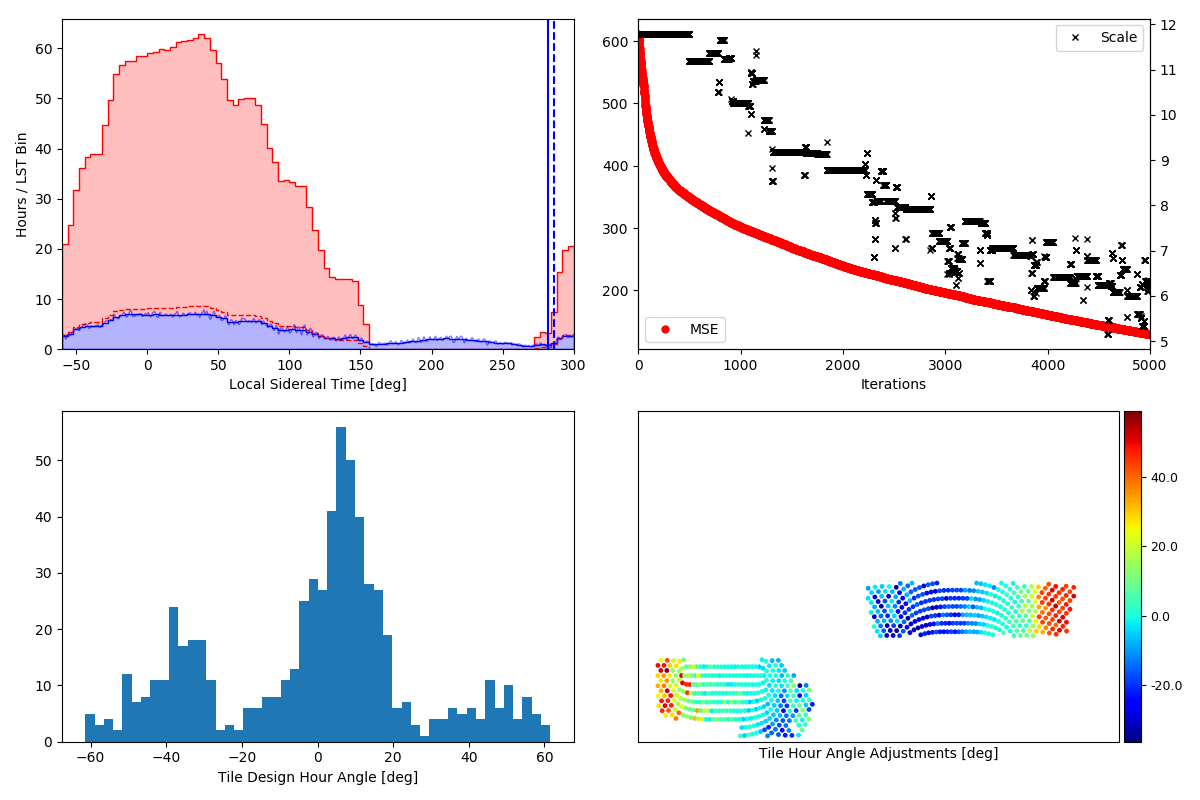

In [3]:
from IPython.display import Image
Image(filename=surveydir+'/plan_2019-08-28_DARK.png', width=500)

Initial `surveysim` takes ~2 minutes

In [5]:
# !time surveysim --seed 123 --strategy HA+fallback --plan plan.fits --verbose

## Read exposures list

Select a subset of tiles in the NGC selected to have dark, gray, and bright while
excluding bright twilight tiles since our sky model doesn't know about twilight yet.

In [4]:
tiles = desimodel.io.load_tiles()
explist = Table.read(surveydir+'/exposures.fits')
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

(10, 25)

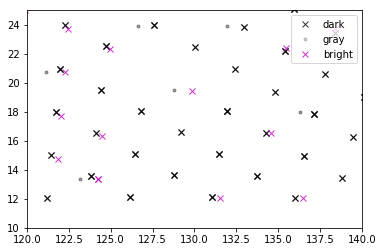

In [5]:
plot(explist['ra'][isdark], explist['dec'][isdark], 'kx', alpha=0.8, label='dark')
plot(explist['ra'][isgray], explist['dec'][isgray], 'k.', alpha=0.2, label='gray')
plot(explist['ra'][isbright], explist['dec'][isbright], 'mx', alpha=0.8, label='bright')
legend(loc='upper right')
xlim(120, 140); ylim(10, 25)

In [6]:
#- Pick 5 tiles nearest RA=130, dec=18
ntiles = 5
xtiles = tiles[np.in1d(tiles['TILEID'], explist['tileid'])]
xyz = hp.ang2vec(xtiles['ra'], xtiles['dec'], lonlat=True)
center = hp.ang2vec(130, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
ii = np.argsort(d2)[0:ntiles]
xtiles = xtiles[ii]
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, xtiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], xtiles['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(xtiles), nexp, len(pixels)))

5 tiles covered by 12 exposures and 58 healpixels


In [7]:
#- row indices of exposures of the selected tiles
iobs = np.where(np.in1d(explist['tileid'], xtiles['TILEID']))[0]
assert np.all(np.in1d(explist['tileid'][iobs], xtiles['TILEID']))
print(iobs)
explist[iobs]

[1407 1408 1409 1410 1513 1514 1791 1792 1798 2023 2024 2025]


tileid,pass,ra,dec,night,mjd,exptime,seeing,airmass,moonfrac,moonalt,moonsep
,,,,,,s,arcsec,,,deg,deg
int32,int16,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64
5326,0,131.95,18.03,2019-10-29,58786.4599208,1116.16574745,0.736597836018,1.28389484728,0.062178465933,-57.1211700439,118.981342038
5326,0,131.95,18.03,2019-10-29,58786.4742283,1199.5791279,0.736597836018,1.28389484728,0.062178465933,-57.1211700439,118.981342038
5326,0,131.95,18.03,2019-10-29,58786.4895012,1226.42659231,0.736597836018,1.28389484728,0.062178465933,-57.1211700439,118.981342038
5326,0,131.95,18.03,2019-10-29,58786.5050848,712.922147952,0.832010805607,1.11035391345,0.062178465933,-50.2612800598,119.416295871
5307,0,129.18,16.6,2019-11-02,58790.4357837,771.11894578,0.707128405571,1.32918633164,0.391961773564,-61.0216178894,171.15523817
5307,0,129.18,16.6,2019-11-02,58790.4460976,855.429854495,0.707128405571,1.32918633164,0.391961773564,-61.0216178894,171.15523817
28357,4,128.77,19.48,2019-11-21,58809.4736434,811.034636678,0.850808739662,1.03610391783,0.236458597303,22.8892936707,59.1188742326
28357,4,128.77,19.48,2019-11-21,58809.4844193,650.423255976,0.850808739662,1.03610391783,0.236458597303,22.8892936707,59.1188742326


In [8]:
pixels

array([4331, 4335, 4346, 4347, 4350, 4629, 4631, 4637, 4639, 4661, 4663,
       4669, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681,
       4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692,
       4694, 4696, 4697, 4698, 4699, 4700, 4702, 4704, 4705, 4706, 4707,
       4708, 4709, 4710, 4711, 4712, 4713, 4716, 4717, 4720, 4721, 4722,
       4723, 4724, 4728])

(13, 23)

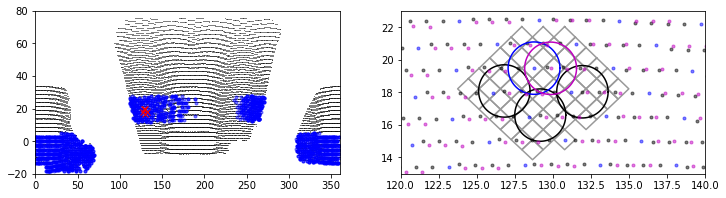

In [9]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

figure(figsize=(12,3))
subplot(121)
plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plot(xtiles['RA'], xtiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(120, 140); ylim(13, 23)

## Run select_mock_targets

This was actually done via an interactive session and using desitarget/sjb for some bug
fixes; see [desitarget #200](https://github.com/desihub/desitarget/pull/200)

In [10]:
#- Write subset of tiles table to file for input to mpi_select_mock_targets
tilefile = targetdir+'/test-tiles.fits'
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
34119,129.86,19.47,5,1,0.0294588,1.05365,2734.11,1.27707,BRIGHT,4
5307,129.18,16.6,0,1,0.0287025,1.06772,2804.48,1.29245,DARK,1
5326,131.95,18.03,0,1,0.0216955,1.06033,2478.84,1.22781,DARK,1
28357,128.77,19.48,4,1,0.0317445,1.05361,2878.96,1.29489,GRAY,2
5308,126.82,18.08,0,1,0.0384451,1.06009,3105.88,1.35914,DARK,1


In [11]:
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets -output_dir {targetdir} --config select-mock-targets.yaml"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile)
print(cmd)

srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -output_dir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --config select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


In [12]:
#- Actually run that command, which will submit a batch job and wait for it to run
### !$cmd

## Merge sky and standards

Requires [desitarget PR #203](https://github.com/desihub/desitarget/pull/203)

In [15]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --force
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/targets.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/truth.fits
INFO:build.py:1004:join_targets_truth: Generating merged target list /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.07593703269958496
DEBUG: calc_priority has 337666 unobserved targets
0 of 337666 targets have priorit

### Do some sanity checks on the results

In [12]:
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [13]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


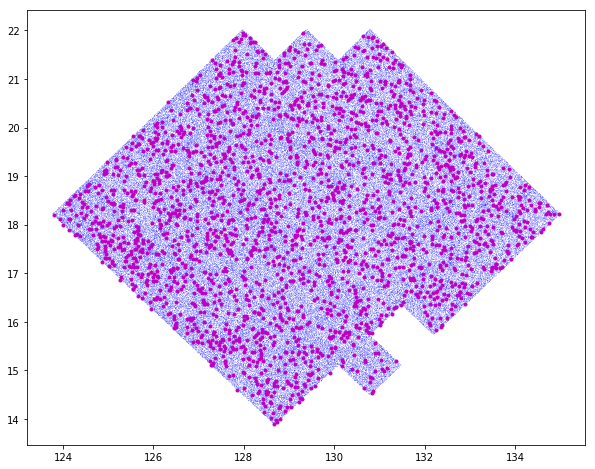

In [14]:
figure(figsize=(10,8))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run fiberassign

First, generate fiberassign configuration files pointing to the right inputs/outputs

In [20]:
!time fiberassign fiberassign-config-bright.txt

 
Targfile /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits 
SStarsfile /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits 
SkyFfile  /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits 
surveyFile /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/dark-tiles.txt 
outDir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign 
 
tileFile /global/common/cori/contrib/desi/code/desimodel/master/data/footprint/desi-tiles.fits 
fibFile /global/common/cori/contrib/desi/code/desimodel/master/data/focalplane/fiberpos.txt 
 
PrintAscii false 
PrintFits true 
diagnose true 
 
kind QSOLy-a QSOTracer LRG ELG FakeQSO FakeLRG SS SF 
type QSO QSO LRG ELG QSO LRG SS SF 
prio 3400 3400 3200 3000 3400 3200 0 0 
priopost 3500 0 3200 0 0 0 0 0 
goal 5 5 2 1 5 2 5 5 
goalpost 5 1 2 1 1 1 5 5 
lastpass 0 0 0 1 0 0 1 1  
SS       0 0 0 0 0 0 1 0 
SF       0 0 0 0 0 0 0 1  
pass_intervals 0 50 100 150 200 
 
Randomize false 
Pacman fals

In [19]:
#- Write list of tiles to consider
dx = open(fibassigndir+'/dark-tiles.txt', 'w')
bx = open(fibassigndir+'/bright-tiles.txt', 'w')
for tileid, program  in zip(xtiles['TILEID'], xtiles['PROGRAM']):
    if program == 'BRIGHT':
        bx.write(str(tileid)+'\n')
    else:
        dx.write(str(tileid)+'\n')

dx.close()
bx.close()

#- Generate config files for dark and bright
cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-dark.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/dark-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-dark.txt".format(fibassigndir)
print(cmd)
!$cmd

cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-bright.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/bright-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-bright.txt".format(fibassigndir)
print(cmd)
!$cmd

config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/dark-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-dark.txt
config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/bright-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-bright.tx

Now run fiberassign itself; requires fiberassign >= 0.5.1

In [31]:
!rm -f $fibassigndir/tile_*.fits
!time fiberassign $fibassigndir/fiberassign-config-dark.txt > $fibassigndir/fa-dark.log
!time fiberassign $fibassigndir/fiberassign-config-bright.txt > $fibassigndir/fa-bright.log
!ls $fibassigndir/tile_*.fits


real	0m6.547s
user	0m3.124s
sys	0m3.232s

real	0m6.935s
user	0m3.036s
sys	0m3.816s
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_05307.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_05308.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_05326.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_28357.fits
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_34119.fits


## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

This requires desisim branch newexp which has not yet been merged into master.
Setup the problem and define the commands to run, but you'll have to run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

In [16]:
# cmd = "srun -N 4 -n 4 -c 32 -C haswell -p debug -t 00:30:00 --qos premium "
nodes = 8

print('#- From a cori login node, set environment variables and then get an interactive job:\n')
for var in ['DESI_SPECTRO_REDUX', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 'PIXPROD', 'SPECPROD']:
    print('export {}={}'.format(var, os.getenv(var)))
print('\nsalloc -N {nodes} -C haswell -t 1:00:00 --qos interactive'.format(nodes=nodes))
print()

cmd = "srun -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
cmd += " --mockdir {}".format(targetdir)
cmd += " --obslist {}/exposures.fits".format(surveydir)
cmd += " --tilefile {}".format(tilefile)
print('#- Then run this in the interactive job:\n')
print(cmd)

#- From a cori login node, set environment variables and then get an interactive job:

export DESI_SPECTRO_REDUX=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux
export DESI_SPECTRO_SIM=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/sim
export DESI_SPECTRO_DATA=/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/sim/mini
export PIXPROD=mini
export SPECPROD=mini

salloc -N 8 -C haswell -t 1:00:00 --qos interactive

#- Then run this in the interactive job:

srun -N 8 -n 8 -c 32 wrap-newexp --mpi --fiberassign /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --obslist /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits --tilefile /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


Ignore warnings like
```
WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the 10s of arcsec level [astropy.coordinates.builtin_frames.utils]
```

## Run fastframe to generate noisy uncalibrated spectra

This also requires the desisim/newexp branch.

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

In [17]:
cmd = "srun -N {nodes} -n {nodes} -c 32 wrap-fastframe --mpi".format(nodes=nodes)
print('#- From the same interactive job, run this:')
print(cmd)

#- From the same interactive job, run this:
srun -N 8 -n 8 -c 32 wrap-fastframe --mpi


## Run the spectro pipeline

  * generate the production scripts
  * launch them

In [29]:
#- Equivalent to running `desi_pipe` from the command line with no arguments
#- Detail: have to provide blank string or otherwise it uses sys.argv which has
#- leftover args from launching jupyter
from desispec.scripts import pipe_prod
args = pipe_prod.parse('--nersc_host cori --nersc_queue debug --fakepix'.split())
pipe_prod.main(args)

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Working with production /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini :
  Updating plans ...
  Creating setup.sh ...
  Selecting nights ...
  Finding max processes supported by workers ...
    bootstrap : 1 processes per task
    psf : 20 processes per task
    psfcombine : 1 processes per task
    extract : 20 processes per task
    fiberflat : 1 processes per task
    sky : 1 processes per task
    stdstars : 1 processes per task
    fluxcal : 1 processes per task
    calibrate : 1 processes per task
    redshift : 192 processes per task
  Generating scripts ...
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
331 nodes too big for debug queue; switching to regular


In [20]:
#- Find nights that observed these tiles
ii = np.in1d(explist['tileid'], xtiles['TILEID'])
nights = unique(np.char.replace(explist['night'][ii], '-', ''))
print(nights)

['20191029' '20191102' '20191121' '20191128']


In [21]:
for night in nights:
    launchcmd = 'sbatch {reduxdir}/run/scripts/{night}/fiberflat-calibrate_{night}.slurm'.format(
        reduxdir=reduxdir, night=night
    )
    print(launchcmd)
    err = subprocess.call(launchcmd.split())
    if err != 0:
        print('ERROR {} while launching {}'.format(err, night))

sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20191029/fiberflat-calibrate_20191029.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20191102/fiberflat-calibrate_20191102.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20191121/fiberflat-calibrate_20191121.slurm
sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20191128/fiberflat-calibrate_20191128.slurm


In [36]:
#- Check on those jobs
qq = 'squeue -u {}'.format(os.getenv('USER'))
!$qq

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


### Check that we got expected outputs
This includes both calibration and science exposures

In [22]:
ii = np.in1d(explist['tileid'], xtiles['TILEID'])
nsci = len(explist[ii])
nflat = 3*len(nights)
nframe = 30*(nsci+nflat)
ncframe = 30*nsci
framefiles = sorted(glob.glob('{}/exposures/*/*/frame*.fits'.format(reduxdir)))
cframefiles = sorted(glob.glob('{}/exposures/*/*/cframe*.fits'.format(reduxdir)))
print('frame {}/{}, cframe {}/{}'.format(len(framefiles), nframe, len(cframefiles), ncframe))

frame 720/720, cframe 360/360


## Regroup spectra from frames -> healpix

In [41]:
#- Equivalent to running `desi_group_spectra --hpxnside 64` from command line (this is slow)
# from desispec.scripts import group_spectra
# args = group_spectra.parse('--hpxnside 64'.split())
# group_spectra.main(args)

#- To run as a batch job instead (including MPI parallelism)
cmd = 'sbatch {}/run/scripts/spectra.slurm'.format(reduxdir)
print(cmd)
# !$cmd

sbatch /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/spectra.slurm
Submitted batch job 6049231


## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-4331.fits
Missing spectra-64-4629.fits
Missing spectra-64-4669.fits


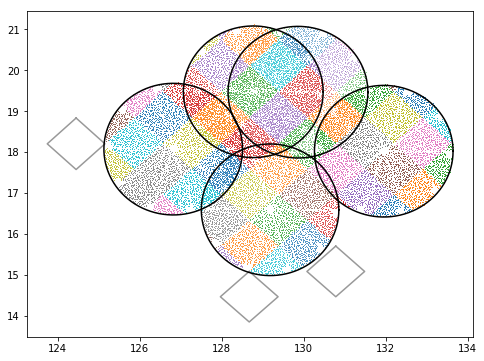

In [23]:
import desispec.io
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in xtiles:
    plot_tile(t['RA'], t['DEC'])

In [24]:
desispec.io.findfile('spectra', groupname=4722)

'/global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64/47/4722/spectra-64-4722.fits'

## Run redrock redshift fitting

TODO: do it, document it

In [25]:
nodes = 15
cmd = 'srun -N {nodes} -n {nodes} -c 32'.format(nodes=nodes)
cmd += ' {}/wrap-redrock --mpi'.format(os.getcwd())
print(cmd)

srun -N 15 -n 15 -c 32 /global/cscratch1/sd/sjbailey/desi/code/two_percent_DESI/mini/wrap-redrock --mpi


#### Sort bricks by number of targets

In [26]:
import desitarget.io

In [27]:
specdir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'), 'spectra-64')
specfiles = list()
for specfile in list(desitarget.io.iter_files(specdir, 'spectra')):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm)
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

specfiles = sorted(specfiles)
specfiles

[(1, 4, 'spectra-64-4350.fits'),
 (6, 6, 'spectra-64-4724.fits'),
 (13, 26, 'spectra-64-4637.fits'),
 (18, 72, 'spectra-64-4700.fits'),
 (23, 46, 'spectra-64-4728.fits'),
 (25, 72, 'spectra-64-4716.fits'),
 (32, 32, 'spectra-64-4702.fits'),
 (52, 74, 'spectra-64-4723.fits'),
 (77, 154, 'spectra-64-4631.fits'),
 (77, 154, 'spectra-64-4717.fits'),
 (141, 423, 'spectra-64-4639.fits'),
 (152, 608, 'spectra-64-4692.fits'),
 (160, 480, 'spectra-64-4712.fits'),
 (168, 672, 'spectra-64-4335.fits'),
 (198, 792, 'spectra-64-4694.fits'),
 (214, 642, 'spectra-64-4663.fits'),
 (220, 660, 'spectra-64-4713.fits'),
 (231, 924, 'spectra-64-4347.fits'),
 (295, 628, 'spectra-64-4676.fits'),
 (307, 614, 'spectra-64-4672.fits'),
 (343, 1029, 'spectra-64-4661.fits'),
 (373, 1492, 'spectra-64-4346.fits'),
 (452, 904, 'spectra-64-4675.fits'),
 (465, 930, 'spectra-64-4673.fits'),
 (480, 1920, 'spectra-64-4688.fits'),
 (485, 1455, 'spectra-64-4704.fits'),
 (496, 1906, 'spectra-64-4690.fits'),
 (500, 1003, 'spec

## Create zcatalog

**TODO**: fix trailing space in TRUESPECTYPE, SPECTYPE

In [19]:
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {reduxdir}/zcatalog.fits'.format(reduxdir=reduxdir)
print(cmd)

desi_zcatalog -i /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog.fits


In [28]:
## Redshift QA
truth = Table.read(targetdir+'/truth.fits')
zcat = Table.read(reduxdir+'/zcatalog.fits')

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [29]:
import astropy.table
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [34]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  3198
LRG  4601
ELG  9798
STAR 1054
BGS  4124


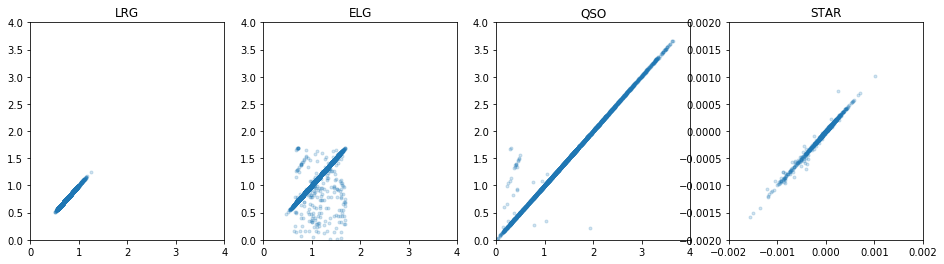

In [35]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.2)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

In [63]:
def zstats(zx, dvlimit=1000, count=False):
    dv = 1e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    good = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] == 0)
    fail = (np.abs(dv)> dvlimit) & (zx['ZWARN'] == 0)
    miss = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] != 0)
    lost = (np.abs(dv)> dvlimit) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

print('        good  fail  miss  lost')
print('        GOOD  FAIL  MISS  LOST')
for objtype in set(ztruth['TEMPLATETYPE']):
    isx = ztruth['TEMPLATETYPE'] == objtype
    pgood, pfail, pmiss, plost = zstats(ztruth[isx])
    print('{:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, pgood, pfail, pmiss, plost))

        good  fail  miss  lost
        GOOD  FAIL  MISS  LOST
STAR    78.0   0.6   5.0  16.4
WD      86.4  12.1   0.0   1.5
ELG     94.9   0.3   2.7   2.1
QSO     98.1   0.7   0.8   0.3
BGS     99.9   0.0   0.0   0.0
LRG    100.0   0.0   0.0   0.0


In [41]:
g = 22.5 - 2.5*np.log10(ztruth['DECAM_FLUX'][:,1])

In [65]:
magbins = np.linspace(16, 24, 17)
midmag = 0.5*(magbins[0:-1] + magbins[1:])
zeff = list()
for i in range(len(magbins)-1):
    maglo, maghi = magbins[i:i+2]
    ismag = (maglo < g) & (g < maghi)
    pgood, pfail, pmiss, plost = zstats(ztruth[isQSO & ismag])
    nmag = np.count_nonzero(isQSO & ismag)
    print('{:.1f}-{:.1f} {:4d} {:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(maglo, maghi, nmag, 'QSO', pgood, pfail, pmiss, plost))
    zeff.append(pgood)


16.0-16.5    0 QSO      nan   nan   nan   nan
16.5-17.0    0 QSO      nan   nan   nan   nan
17.0-17.5    4 QSO    100.0   0.0   0.0   0.0
17.5-18.0   13 QSO    100.0   0.0   0.0   0.0
18.0-18.5   31 QSO    100.0   0.0   0.0   0.0
18.5-19.0   74 QSO     98.6   0.0   0.0   1.4
19.0-19.5  136 QSO     98.5   0.7   0.7   0.0
19.5-20.0  193 QSO     99.5   0.0   0.5   0.0
20.0-20.5  330 QSO     98.2   0.6   1.2   0.0
20.5-21.0  386 QSO     99.2   0.3   0.5   0.0
21.0-21.5  532 QSO     99.2   0.8   0.0   0.0
21.5-22.0  524 QSO     97.3   1.5   0.8   0.4
22.0-22.5  598 QSO     98.8   0.5   0.5   0.2
22.5-23.0  352 QSO     96.0   0.9   2.8   0.3
23.0-23.5   25 QSO     68.0   4.0   8.0  20.0
23.5-24.0    0 QSO      nan   nan   nan   nan


In [61]:
magbins

array([16])

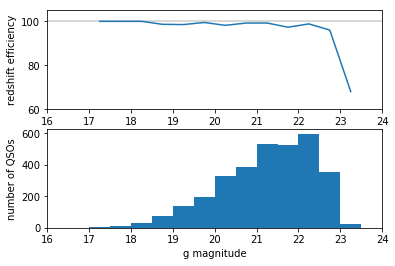

In [77]:
subplot(211)
axhline(100, color='0.8')
plot(midmag, zeff)
xlim(magbins[0], magbins[-1])
ylabel('redshift efficiency')
ylim(60,105)

subplot(212)
hist(g[isQSO], len(magbins)-1, (magbins[0], magbins[-1]))
xlim(magbins[0], magbins[-1])
xlabel('g magnitude')
ylabel('number of QSOs')

In [57]:
np.linspace(16, 24, 17)

array([ 16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,
        20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ])